Data preview:
   timestep  infected_person_id  infected_age  infected_sex  infected_masked  \
0         0                   3            24             1            False   
1         0                   4            38             1            False   
2     10500                  11            23             0            False   
3     10500                  70            25             0            False   
4     10560                  39            30             0            False   

   infected_vaccination_doses  infector_person_id  infector_age  infector_sex  \
0                           0                 NaN           NaN           NaN   
1                           0                 NaN           NaN           NaN   
2                           0               154.0          23.0           0.0   
3                           0                80.0          56.0           1.0   
4                           0                 4.0          38.0           1.0   

   infector_masked

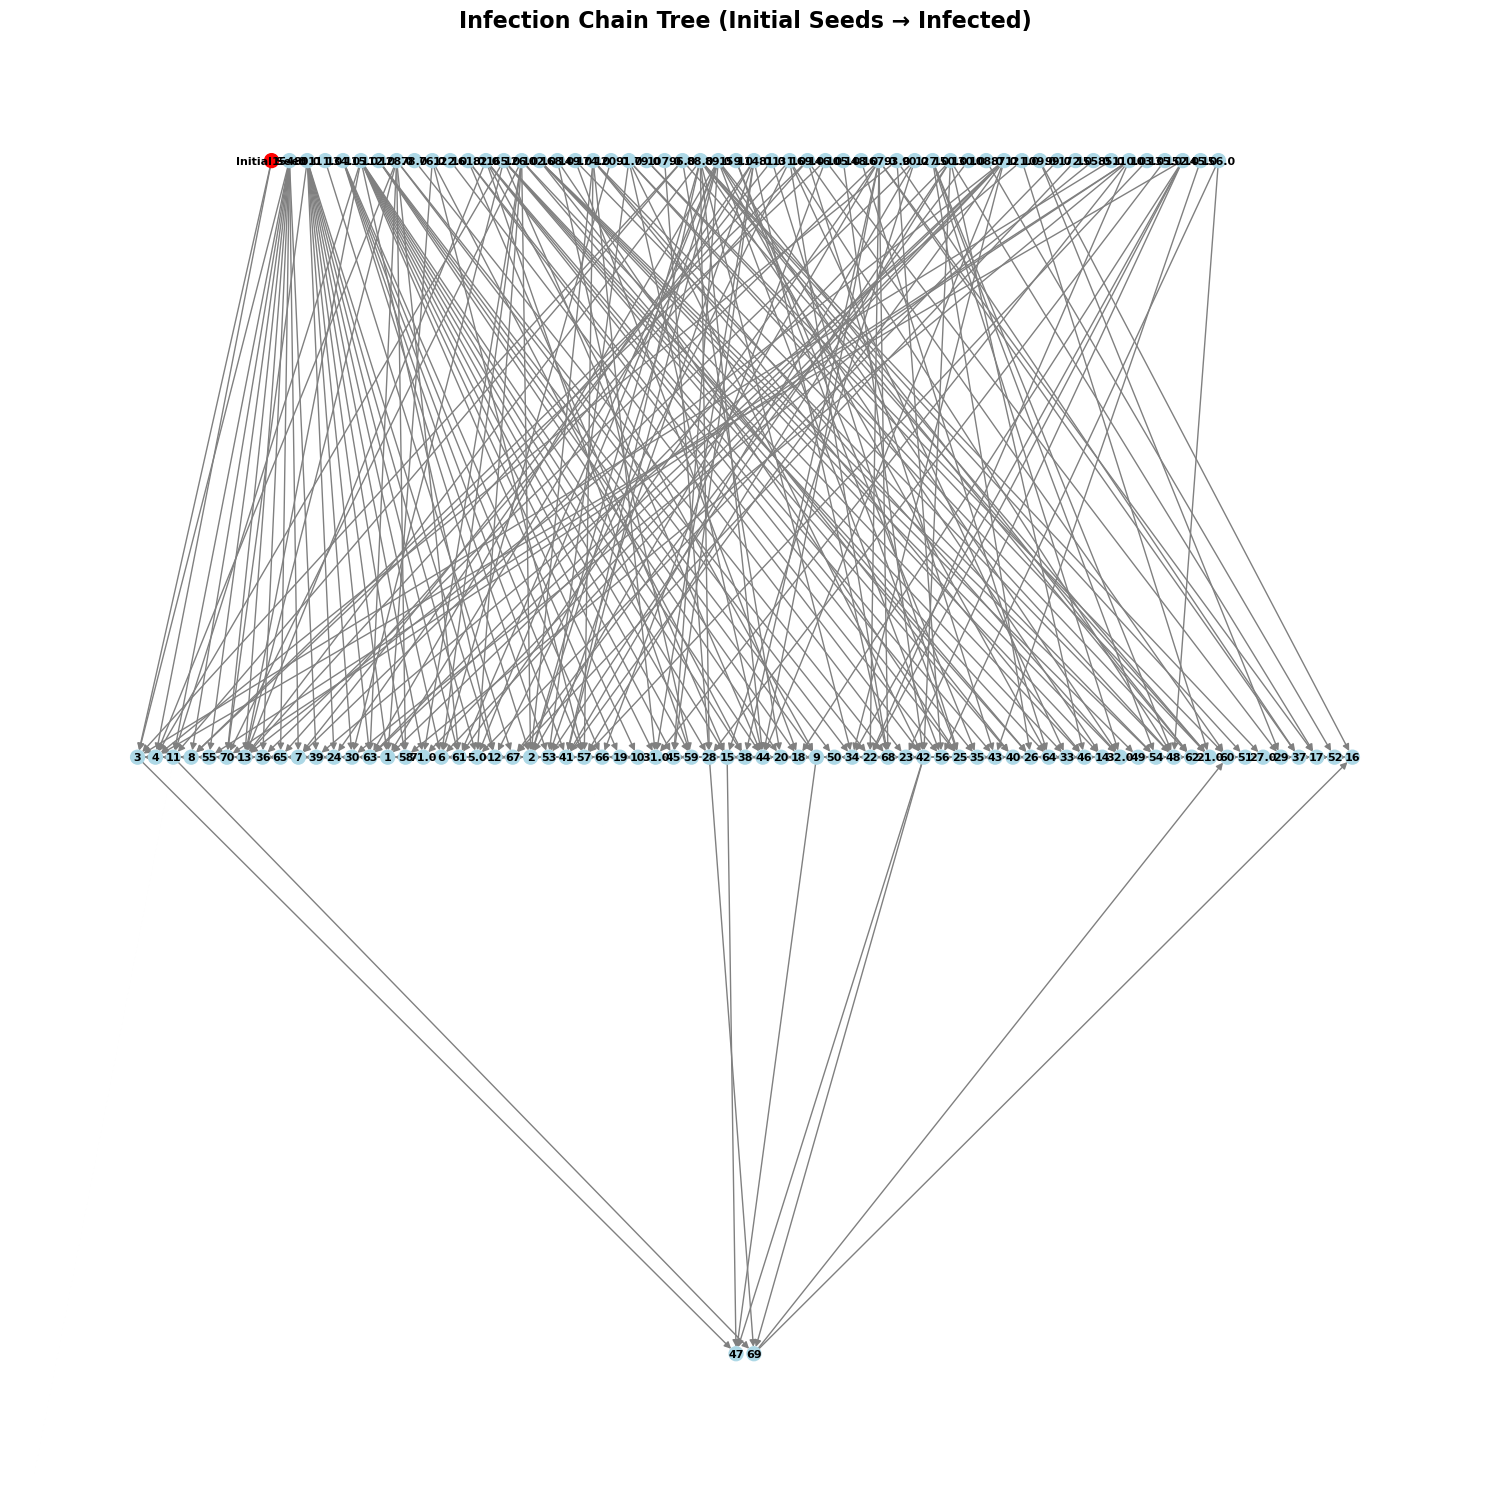

In [ ]:
# Generate infection chain graph based on infection_logs.csv 

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import math

# Read the CSV file
df = pd.read_csv("../data/raw/sample_2/infection_logs.csv")
print("Data preview:")
print(df.head())

# Create directed graph
G = nx.DiGraph()

# Add edges for infection chains
for index, row in df.iterrows():
    infector_person = row['infector_person_id']
    infected_person = row['infected_person_id']
    
    # Handle initial seeds (no infector)
    if pd.isna(infector_person) or infector_person == '':
        infector_person = 'Initial Seed'
    
    # Add edge from infector to infected (corrected direction)
    G.add_edge(infector_person, infected_person)

# Try different layout methods based on what's available
plt.figure(figsize=(15, 15))

try:
    # Use hierarchical layout with dot program for tree structure
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
except:
    # Fallback: Create manual hierarchical layout
    # Get all nodes with no predecessors (roots/initial seeds)
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    
    # Use a simple hierarchical positioning
    pos = {}
    levels = {}
    
    # BFS to assign levels
    from collections import deque
    queue = deque([(root, 0) for root in roots])
    
    while queue:
        node, level = queue.popleft()
        if node not in levels:
            levels[node] = level
            for successor in G.successors(node):
                queue.append((successor, level + 1))
    
    # Position nodes by level
    level_counts = {}
    for node, level in levels.items():
        if level not in level_counts:
            level_counts[level] = 0
        level_counts[level] += 1
    
    level_positions = {}
    for node, level in levels.items():
        if level not in level_positions:
            level_positions[level] = 0
        
        # Position: x based on order within level, y based on level (top to bottom)
        x = level_positions[level] - (level_counts[level] - 1) / 2
        y = -level  # Negative to put roots at top
        pos[node] = (x, y)
        level_positions[level] += 1

# Draw the network with different colors for different levels
node_colors = []
for node in G.nodes():
    if node == 'Initial Seed':
        node_colors.append('red')  # Initial seeds in red
    elif G.in_degree(node) == 1 and list(G.predecessors(node))[0] == 'Initial Seed':
        node_colors.append('orange')  # First generation in orange
    else:
        node_colors.append('lightblue')  # Others in light blue

nx.draw_networkx(G, pos, 
                with_labels=True, 
                node_color=node_colors, 
                node_size=1800,
                font_size=8, 
                font_weight='bold', 
                arrowsize=10,
                edge_color='gray',
                arrows=True)

plt.title("Infection Chain Tree (Initial Seeds → Infected)", fontsize=16, fontweight='bold')
plt.axis('off') 
plt.tight_layout()